# Introduction

This framework uses Mlflow Tracking Server to manage, track, tag the model artifacts,  and uses Ray as the backend inferencing engine to do batch inferencing very efficiently. The end users are data scientists (DS). The subcommands of CLI **"ecsml"** help DS to do the following operations.

<br/>

- **Subcommands for managing projects**
    - new                    -- create a new project in your local ML inference framework
    - switch                 -- switch to another project
    - list                   -- Display a list of all projects within the framework.
    - current                -- Display the project the user is working on
    - status                 -- show current project status
    - help                   -- Will display this menu
  

- **Subcommands for the working project**
    - initialize             -- set up conda env & jupyter kernel; install packages defined in requirements.txt
    - test                   -- pytest application.py
    - modelregister          -- Log and Register model
    - imagebuild             -- Prepare Dockerfile & Build Image
    - imagescan              -- Local Image Testing & Vulnerability Scan
    - cleanup                -- delete conda env and jupyter kernel; the project artifacts will be kept

In [ ]:
# try ecsml CLI
!ecsml help

# Manage Projects

In [ ]:
# list all the projects
!ecsml list

In [ ]:
# Define the model you want to work on:
import os
WORKING_PROJECT = os.path.basename(os.getcwd())

In [ ]:
#switch to an existing project if you have worked on it before
!ecsml switch {WORKING_PROJECT}

In [ ]:
!ecsml current

# Work on inference codes

Before coding, if you are working on a new model deployment or a redeployment for a retrained model, you need to create a feature branch:

In [ ]:
!git checkout -b "feature-{WORKING_PROJECT}-model" 

The structure of a particular project is shown below

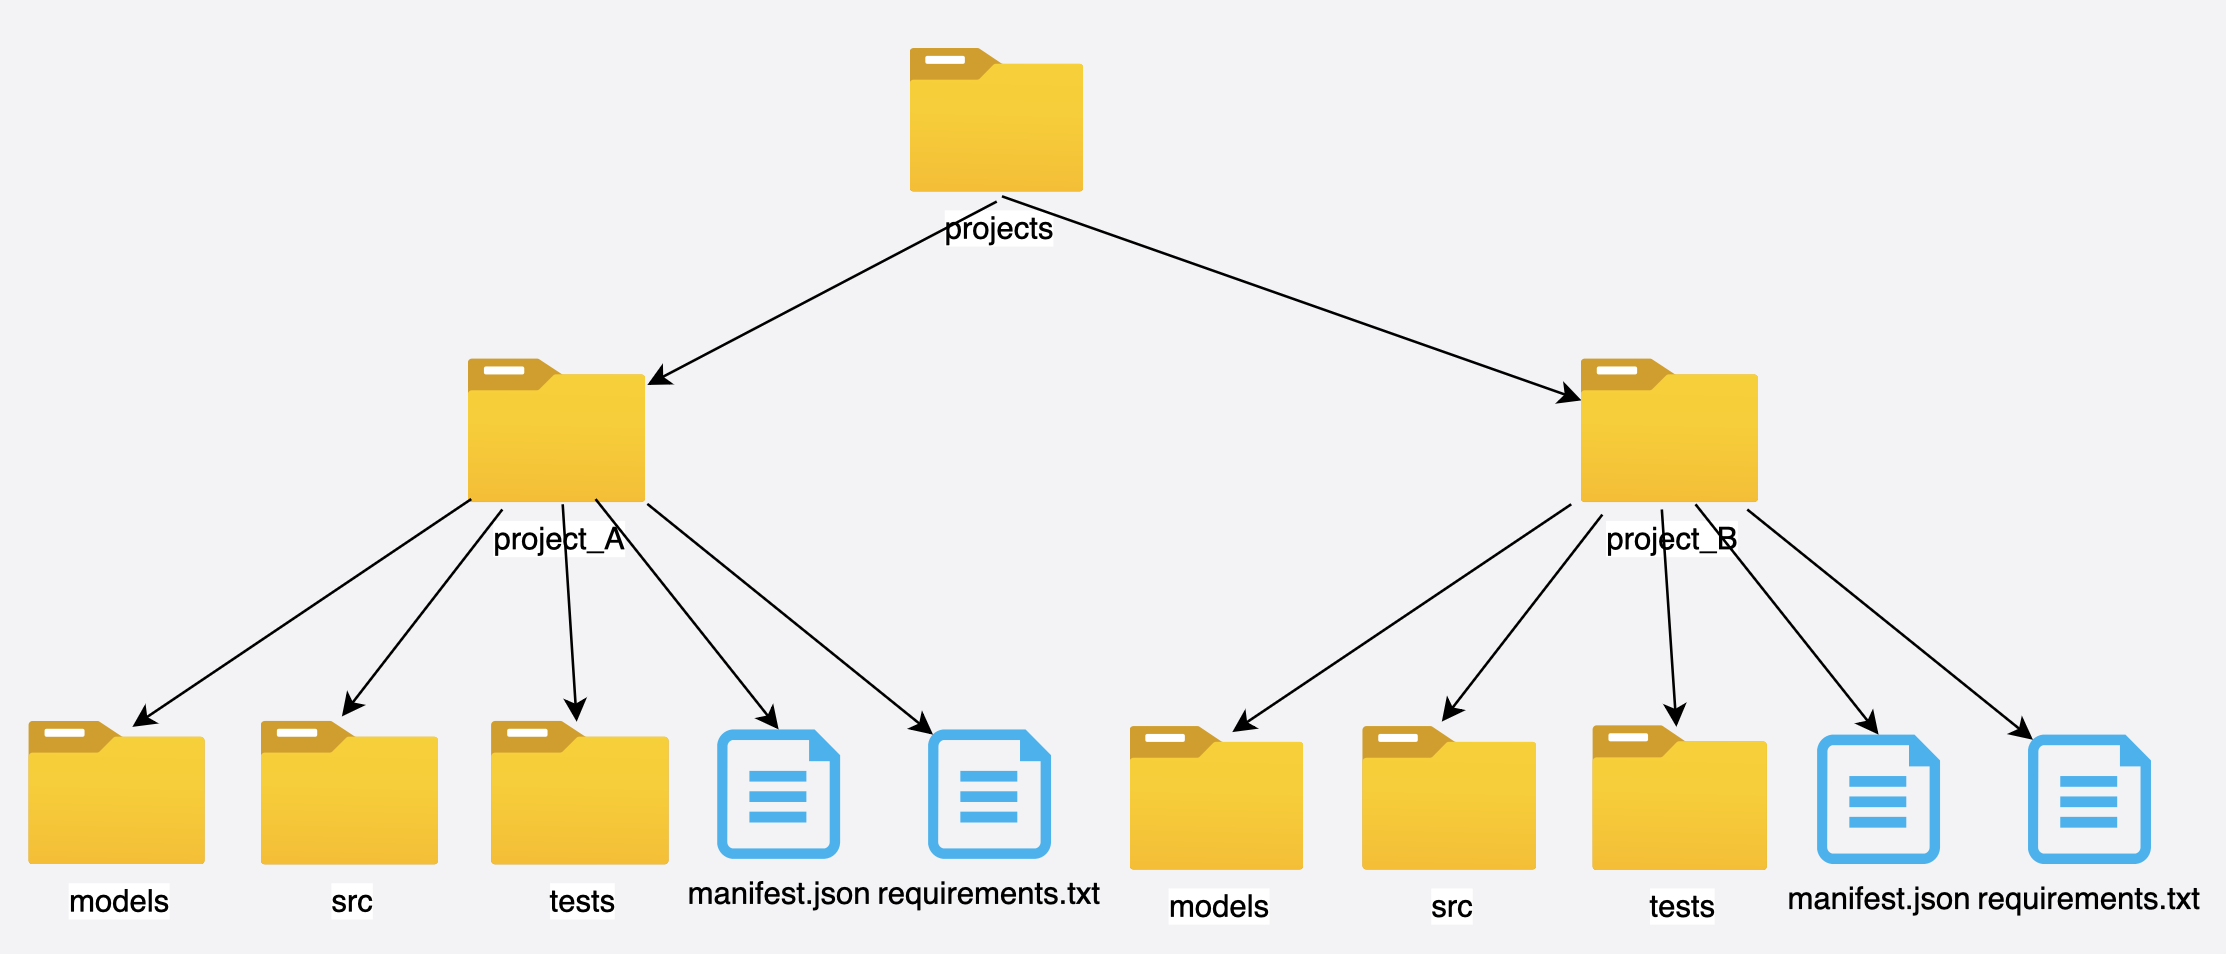

## Preparation before coding

**If you just created a new project, you need to prepare files and folders by following the steps below before working on your inferencing codes.**

1. models folder: all the model files (the artifacts created during model training) should be moved to “models” folder.

2. src folder: Any custom python scripts required by model loading and inferencing should be copied to “src” folder. For example, if you have a custom preprocessor created in training and the source code is saved as "my_preprocessor.py", you need to 2 things to make infencing code work:
     - pickle the preprocessor after training, and copy the pickled file to "models" folder
     - copy "my_preprocessor.py" to "src" so that the inference code can successfully unpickle the object.

3. tests folder: 2 test files should be prepared in tests folder. “css”, “json” and “parquet” formats are supported. 
      - one file should have all the feature columns 
      - the other contains the prediction results.

4. manifest.json file: 
    - "input_params": you can add key-value pairs under it; the values can be retrieved in the inference codes
    - "meta_info": you can add key-value pairs under it for logging / tagging.
    - “test_config": please provide the file names and formats, for example:
    ```
    "test_config": {
        "feature_data": "test_data.json",
        "feature_format": "json",
        "target_data": "target.csv",
        "target_format": "csv"
    }
    ```

## Project Initialization and dependency installation

In [ ]:
# set up conda env named with the project name
# create the jupyter notebook kernal with the same name
# install dependencies defined in "requirements.txt"
!ecsml initialize

In [ ]:
!conda-env list

## Inference coding

Once the 4 steps are done, you need to work on script **"application.py"** under "src" folder. In the script, there are 2 important methods, load_model() and make_prediction().
- load_model method: invoked only once to load ML model(s) when worker starts. Understand it as app level bootstrapping.
- make_prediction method: invoked during inferencing. Understand it as request level when new requests arrive.

The values set under "input_params" in manifest.json can be retrieved from self.input_params in the code. For example, if you have this snippet:
```
    "input_params":{
        "models_seq": ["autoinsurance","creditcards","personalloans","subscription","transactional"],
        "id_column": "a string, "customerid""
     }
```
In application.py, you can retrieve them by using the codes below:
```
    # you will get a string, "customerid"
    self.input_params["id_column"]

    # you will get a list
    self.input_params["models_seq"]
```

## Unit testing

Once you have done all the tasks below, you can test if your inferencing code makes the predictions as expected.
- finish the coding in application.py
- prepare the 2 test files in "tests" folder
- set "test_config" in "manifest.json" file

Behind the scene, the framework makes predictions on the test data and compares the results to the target results. It will pass the unit testing if the two exactly match.

In [ ]:
# if you want to just run the unit test
!ecsml test force

In [ ]:
# besides the unit testing, if you also want to save the prediction results, run the following command
# the prediction results will be saved in the "tests" folder, the name format is "prediction_{timestamp}.csv"
!ecsml test save

# Model Registration

If your codes pass the unit testing, you can register your model to MLflow server. With one command, this framework provides hassle-free experience by hiding all the following details under the hood:
- export the dependencies based on what python libs are used by your codes
- package all the artifacts including models, codes, test data and dependencies.
- upload the artifacts to the cloud storage (S3), and this may take time depending on the model sizes
- log the model as one experiment in MLflow server
- register the model in MLflow server


In [ ]:
!ecsml modelregister force

# Prepare Dockerfile & Build Image

**Prerequisite: app "Docker Desktop" needs to be installed and running, use the link below to install:**

https://www.docker.com/products/docker-desktop/

Once you decide to use the registered model to build the image, you can use the CLI to create the docker images. The purpose of creating local images is:
1. the image is exactly the same as the one which will be deployed in the cloud environment
2. the image creation includes unit testing as the last step; if the unit testing is successful, the image creation in the cloud will too
3. vulnerability scan on the local image may reveal some high/critical security issues on some python libs used by the inference codes; DS need to fix them before checking in the codes.


In [ ]:
!ecsml imagebuild force

# Vulnerability Scan

In [ ]:
!ecsml imagescan force

# General Development Workflow

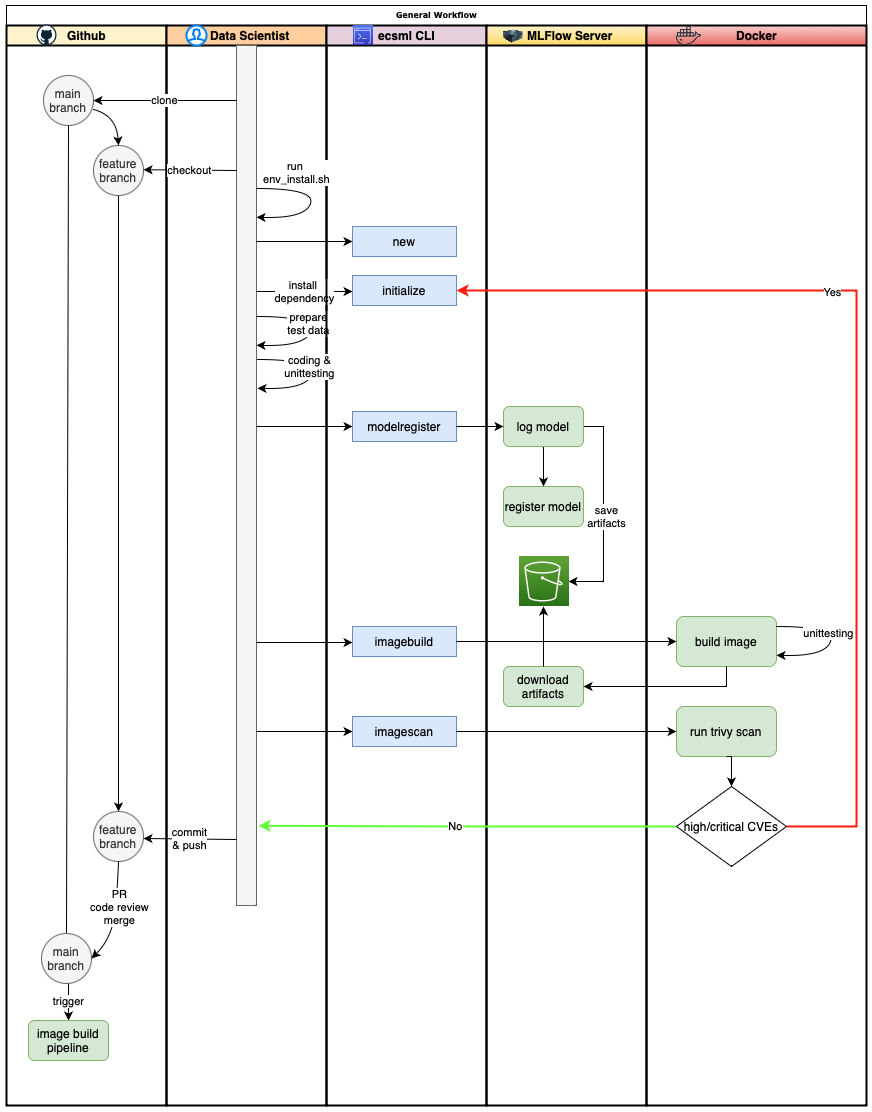

## Clean Up (Optional)

The cleanup deletes the conda env and all the packages installed there; it will also delete "build" folder under working project's folder. The purpose of it is to release some local disk space from the projects which are already deployed in the cloud.

Uncomment it if you want to run this step.

In [ ]:
# !ecsml cleanup

## Push your codes to Git

In [ ]:
!git add .
!git add ../../model-image-info.json

In [ ]:
!git status

In [ ]:
!git commit -m "Image Build Project {WORKING_PROJECT}"

In [ ]:
!git push --set-upstream origin feature-{WORKING_PROJECT}-model 

## Trigger Image Build Pipeline (CI/CD)

In your browser, go to the git repo: https://github.com/ecs-ml-automation/ecs-ml-inference-framework; start the Pull Request from your feature branch to main branch. It will trigger the image build pipeline, which will build the image, do the vulnerability scan, and register it in aws ECR.